In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("ICBHI 2017/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")
df.head()

,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


In [3]:
df['URTI'].unique()

array(['Healthy', 'Asthma', 'COPD', 'URTI', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [4]:
sr_no = {'101':'URTI'}
for i, j in zip(df['101'].unique(), df['URTI']):
    sr_no[str(i)] = j

In [5]:
sr_no.keys()

dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226'])

In [6]:
import os
sound_files = os.listdir('Mel Spectrogram/Original')

In [7]:
req_file_names = []

for i in sound_files:
      req_file_names.append([i])

In [8]:
labels = []
for i in range(len(req_file_names)):
    req_file_names[i].append(sr_no[req_file_names[i][0][:3]])
    labels.append(sr_no[req_file_names[i][0][:3]])

In [9]:
labels *= 3

In [10]:
x = []

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Time Stretch/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Pitch Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)
    
for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Audio Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

# x = np.array(x)
# print(x.shape)

In [11]:
x_new = []
y = []

for i in range(len(labels)):
    if labels[i]=='Asthma' or labels[i]=='Bronchiolitis':
        continue
    x_new.append(x[i])
    y.append(labels[i])

In [12]:
x = np.array(x_new)
print(x.shape)

(2718, 350, 350, 3)


In [13]:
req_file_names *= 3

In [14]:
y = np.array(y)
y.shape

(2718,)

In [15]:
one_hot_y = np.array(pd.get_dummies(y))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, one_hot_y, test_size=0.2, random_state=39, stratify=y)
print(x_train.shape, y_train.shape, x_test.shape)

(2174, 350, 350, 3) (2174, 6) (544, 350, 350, 3)


In [17]:
enb0_wo_top = keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(350,350,3))

In [18]:
enb0_xtrain = enb0_wo_top.predict(x_train)
enb0_xtest = enb0_wo_top.predict(x_test)

In [19]:
del x
del x_new
del x_train
del x_test
del enb0_wo_top

In [19]:
input_enb0 = keras.layers.Input(shape=enb0_xtrain.shape[1:])

# enb0_layer = enb0_wo_top(input_enb0)

# random = np.random.random(enb0_layer.shape[1:])

attention = keras.layers.Attention()([input_enb0, input_enb0])
flatten = keras.layers.Flatten()(attention)

dense1 = keras.layers.Dense(128, activation='relu')(flatten)
do1 = keras.layers.Dropout(0.3)(dense1)
bn1 = keras.layers.BatchNormalization()(do1)
dense2 = keras.layers.Dense(64, activation='relu')(bn1)
output = keras.layers.Dense(6, activation='softmax')(dense2)

enb0_model = keras.Model(inputs=input_enb0, outputs=output)
enb0_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11, 11, 128  0           []                               
                                0)]                                                               
                                                                                                  
 attention (Attention)          (None, 11, 11, 1280  0           ['input_2[0][0]',                
                                )                                 'input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 154880)       0           ['attention[0][0]']              
                                                                                              

In [20]:
checkpoint_enb0 = keras.callbacks.ModelCheckpoint('/kaggle/working/ENB0_Model-{epoch:02d}.h5', save_best_only=True, initial_value_threshold=0.9980)

enb0_model.compile(optimizer=keras.optimizers.Adam(3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_enb0 = enb0_model.fit(enb0_xtrain, y_train, batch_size=32, epochs=250, validation_data=(enb0_xtest, y_test), callbacks=[checkpoint_enb0])

Epoch 1/250
68/68 [==============================] - 6s 47ms/step - loss: 1.3399 - accuracy: 0.4876 - val_loss: 0.9014 - val_accuracy: 0.8585
Epoch 2/250
68/68 [==============================] - 2s 34ms/step - loss: 0.9551 - accuracy: 0.7383 - val_loss: 0.8256 - val_accuracy: 0.8695
Epoch 3/250
68/68 [==============================] - 2s 33ms/step - loss: 0.8318 - accuracy: 0.7971 - val_loss: 0.6833 - val_accuracy: 0.8824
Epoch 4/250
68/68 [==============================] - 2s 30ms/step - loss: 0.7765 - accuracy: 0.8243 - val_loss: 0.6157 - val_accuracy: 0.8971
Epoch 5/250
68/68 [==============================] - 3s 39ms/step - loss: 0.7158 - accuracy: 0.8454 - val_loss: 0.5741 - val_accuracy: 0.9062
Epoch 6/250
68/68 [==============================] - 2s 31ms/step - loss: 0.6844 - accuracy: 0.8569 - val_loss: 0.5546 - val_accuracy: 0.9062
Epoch 7/250
68/68 [==============================] - 2s 37ms/step - loss: 0.6692 - accuracy: 0.8744 - val_loss: 0.4984 - val_accuracy: 0.9118
Epoch 

In [22]:
df = pd.DataFrame(history_enb0.history)
df.to_csv('/kaggle/working/ENB0_history.csv')

In [20]:
enb0_model = keras.models.load_model("Results/ENB0_Model-134.h5")

TypeError: ('Keyword argument not understood:', 'score_mode')

In [ ]:
y_pred = enb0_model.predict(enb0_xtest)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_test:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

In [ ]:
y_pred = enb0_model.predict(enb0_xtrain)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_train:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

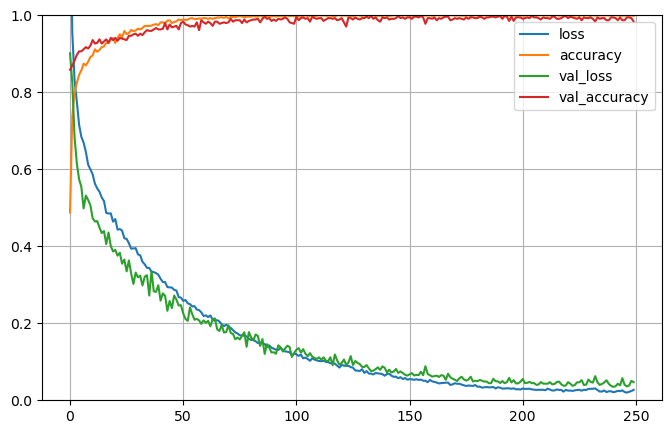

In [28]:
pd.DataFrame(history_enb0.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig("/kaggle/working/ENB0_Attention_Graph.png")
plt.show()